# Hartree-Fock - Self Consistent Field (SCF) cycle

### Procedure (Szabo)

1. Specify a molecule (H2 in this case) and a basis set {$\phi_\mu$} (STO-3G in this case)
2. Calculate all required molecular integrals
3. Diagonalize the overlap matrix and get the transformation matrix $X$
4. Guess a density matrix $P$
5. Build the G and F matrix 
6. Calculate the trnasformed Fock matrix $F' = X^\dagger F X$
7. Diagonalize $F'$ to obtain $C'$ and $\varepsilon$
8. Go back to the original representation $C = X C'$
9. Form a new density matrix $P = CC^\dagger$
10. Check convergence
11. Compute expectation values after convergence 

In [1]:
import numpy as np
from Utils import * # Import functions from the previous notebook
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams["figure.figsize"] = (10,8)
plt.rcParams.update({'font.size': 15})

In [7]:
def compute_G(density_matrix, V_ee):
    
    n_basis = density_matrix.shape[0] # Number of atoms
    G = np.zeros((n_basis,n_basis))
    
    for i in range(n_basis):
        for j in range(n_basis):
            for k in range(n_basis):
                for l in range(n_basis):
                    J = V_ee[i,j,k,l]
                    K = V_ee[i,l,k,j]
                    G[i,j] += density_matrix[k,l] * (J-0.5*K)
                    
    return G                
    

def compute_density_matrix(MOs):
    
    n_basis = MOs.shape[0] # Number of atoms
    density_matrix = np.zeros((n_basis,n_basis))
     
    for i in range(n_basis):
        for j in range(n_basis):
            for a in range(int(n_basis/2)):
                C = MOs[i,a]
                C_dagger = MOs[j,a]
                density_matrix[i,j] += 2 * C_dagger * C  
    
    return density_matrix
    

def compute_electronic_energy(density_matrix, T, V_ne, G):
    
    n_basis = density_matrix.shape[0]
    H_core = T + V_ne
    electronic_energy = 0.
    
    for i in range(n_basis):
        for j in range(n_basis):
            electronic_energy += density_matrix[i,j] * (H_core[i,j] + 0.5*G[i,j])             
            
    return electronic_energy
    
    

def scf_cycle(molecular_terms, scf_parameters, molecule):
    
    S, T, V_ne, V_ee = molecular_terms # Terms contributing to electronic energy
    tol, max_steps = scf_parameters # Tolerance and maximum number of scf cycles
    electronic_energy = 0.
    
    n_basis = len(molecule) # Number of atoms
    density_matrix = np.zeros((n_basis,n_basis))
    
    # 1. Enter into de SCF cycles
    for scf_step in range(max_steps):
        
        electronic_energy_old = electronic_energy
        
        # 2. Compute the 2 electron terms and add them to the 1 electron term of HF equations
        G = compute_G(density_matrix, V_ee)
        
        # 3. Build F, make S unit and get the eigenvalues/vectors from Roothan's equations
        F = T + V_ne + G
        S_inv_sqrt = linalg.sqrtm(linalg.inv(S)) # Matrix that converts S into I 
        F_unitS = np.dot(np.transpose(S_inv_sqrt),np.dot(F,S_inv_sqrt)) # Transformation of F when S=I
        eigvals, eigvecs = linalg.eigh(F_unitS) # Eigenvals/vecs of F when S=I
        MOs = np.dot(S_inv_sqrt, eigvecs) # Returning to the solution when S =/= I
        
        # 4. Get a new density matrix from the MOs
        density_matrix = compute_density_matrix(MOs)
        
        # 5. Compute electronic energy
        electronic_energy = compute_electronic_energy(density_matrix, T, V_ne, G)
        
        # 6. Check convergence
        if abs(electronic_energy-electronic_energy_old) < tol:
            #print("SCF converged")
            return electronic_energy
        
    #print("SCF not converged")    
    return electronic_energy

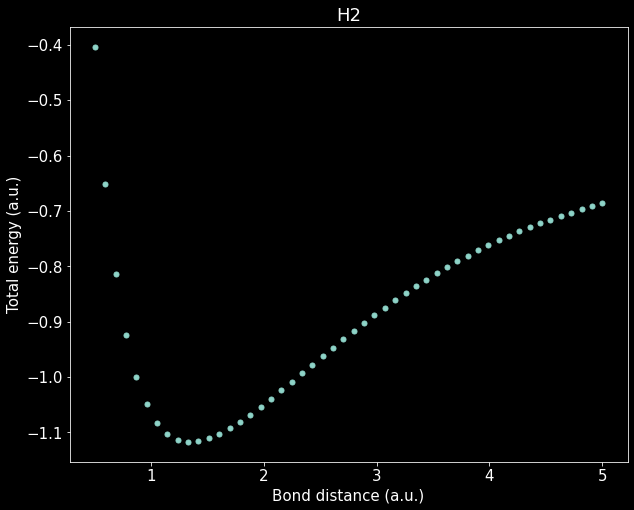

In [8]:
# CREATE H2 MOLECULES 

n_points = 50 # Number of distances
distances = np.linspace(0.5,5,n_points) # Bond distances
molecule_coords = [ [np.array([0,0,0]),np.array([0,0,d])] for d in distances] # Molecular coordinates for all different bond distances

molecules = [[] for _ in range(n_points)] # All molecules at different bond distances
Z = [1.,1.] # Atomic numbers of nuclei

total_energy = [] # Total energy of the atom


for n in range(n_points):
    
    for i in range(len(Z)):
        molecules[n].append( [ primitive_gaussian(0.3425250914E+01,0.1543289673E+00,molecule_coords[n][i]),
                               primitive_gaussian(0.6239137298E+00,0.5353281423E+00,molecule_coords[n][i]),
                               primitive_gaussian(0.1688554040E+00,0.4446345422E+00,molecule_coords[n][i])] )
    
    # COMPUTE SCF ENERGY (ELECTRONIC ENERGY)
    molecular_terms =[ overlap(molecules[n]),
                       kinetic(molecules[n]),
                       electron_nuclear_attraction(molecules[n], molecule_coords[n], Z),
                       electron_electron_repulsion(molecules[n]) ]
    
    scf_parameters = [1e-6, 50]
    
    electronic_energy = scf_cycle(molecular_terms,scf_parameters,molecules[n])
    
    # COMPUTE TOTAL ENERGY = ELECTRONIC ENERGY + NUCLEAR ENERGY
    total_energy.append(electronic_energy + nuclear_nuclear_repulsion(molecule_coords[n], Z))

# PLOT BOND DISSOCIATION CURVE   
plt.title("H2")
plt.xlabel("Bond distance (a.u.)")
plt.ylabel("Total energy (a.u.)")
plt.plot(distances, total_energy, '.',ms=10)